In [1]:
import os

import sys
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\src")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\venv")

path = os.getcwd()

curr_path = path.replace('\\', '/')
head_place = curr_path.find('GIEBN')
main_path = curr_path[:head_place]+'GIEBN'
main_path

'c:/Users/User/PycharmProjects/GIEBN'

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from sklearn.model_selection import train_test_split

from auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI
import shap

from tqdm import tqdm

imagespath = 'C://Users/User/PycharmProjects/GIEBN/experiments/shaplime/images'

In [3]:
%run ../common_code.ipynb

In [4]:
data = pd.read_csv("../../datasets/credit.csv")
print(data.columns)
#data = data.reset_index().drop(columns=["index"])
n_features = data.shape[1]-1
n = data.shape[0]
data["default"] = (data["NumberOfTimes90DaysLate"] > 0).astype(int)
data.drop(columns=["NumberOfTimes90DaysLate", 'NumberOfTime60-89DaysPastDueNotWorse', 'SeriousDlqin2yrs',
                   'NumberOfTime30-59DaysPastDueNotWorse'], inplace=True)
n_features = data.shape[1]-1
n = data.shape[0]
data.rename(columns={feat: "".join(feat.split("-")) for feat in data.columns}, inplace=True)
target = "default"
features = data.columns.difference([target]).tolist()

data.head(10)

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'SeriousDlqin2yrs'],
      dtype='object')


,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,default
0,0.006999,38,0.302150,5440.0,4,1,3,0
1,0.704592,63,0.471441,8000.0,9,1,0,0
2,0.063113,57,0.068586,5000.0,17,0,0,0
3,0.368397,68,0.296273,6250.0,16,2,0,0
4,1.000000,34,0.000000,3500.0,0,0,1,0
5,0.051799,63,0.770687,4700.0,16,1,1,0
6,0.648733,40,0.402060,6600.0,10,2,3,0
7,0.767270,33,0.338390,5800.0,10,0,3,0
8,0.190111,27,0.164605,3960.0,6,0,1,0
9,0.139989,65,0.258397,6400.0,6,1,0,0


In [5]:
data_tv, data_test = train_test_split(data, test_size=0.15, random_state=42,
                                      stratify=data[target])

data_train, data_val = train_test_split(data_tv, test_size=0.15, random_state=42,
                                      stratify=data_tv[target])

data_train[target].mean(), data_val[target].mean() , data_test[target].mean()

(0.18476190476190477, 0.18488972313467855, 0.18460925039872408)

In [6]:
data_val.shape

(2131, 8)

In [7]:
model = GradientBoostingClassifier(n_estimators=30)
#model = LogisticRegression()
model.fit(data_train[features], data_train[target])

GradientBoostingClassifier(n_estimators=30)

In [8]:
data_errors = data_val.copy(deep=True)
probs = model.predict_proba(data_val[features])[:, 1]
data_errors["inconf_error"] = (1-probs)*data_val[target]+(probs)*(1-data_val[target]) #inconfidence measure: the larger the worser inconfidence

data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,inconf_error
700,1.000000,54,0.178841,3175.0,1,0,1,0.485031
15405,1.000000,35,0.000000,1800.0,0,0,0,0.573427
16522,0.197965,49,0.120713,9708.0,7,2,2,0.061616
3834,0.107234,80,0.271530,2960.0,8,1,0,0.054690
10225,0.594406,39,0.537291,4665.0,6,1,4,0.177077


In [9]:
disc_data, pipeline_data = discretize(data_errors, features+["inconf_error"], icat=None, icont=list(range(n_features+1)))
disc_data

,DebtRatio,MonthlyIncome,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,RevolvingUtilizationOfUnsecuredLines,age,inconf_error
0,0,0,0,0,0,1,1,1
1,0,0,0,0,0,1,0,1
2,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,2,0
4,0,0,2,0,0,1,0,0
...,...,...,...,...,...,...,...,...
2126,0,0,1,0,0,1,0,1
2127,0,0,0,0,0,1,0,1
2128,0,0,1,1,0,0,1,0
2129,0,0,0,0,0,1,0,1


In [10]:
q = np.linspace(0, 1, 11)
dicval = {feat: [data_errors[feat].quantile(qu) for qu in q] for feat in pipeline_data["cont_features"]}
#dicval

In [11]:
q = np.linspace(0, 1, 11)
dicval = {feat: [data_errors[feat].quantile(qu) for qu in q] for feat in pipeline_data["cont_features"]}
#dicval
v = pipeline_data["cont_features_edges"]
for i in [0, 2, 3, 5, 7]:
    v[i] = [v[i][0], dicval[pipeline_data["cont_features"][i]][3], dicval[pipeline_data["cont_features"][i]][7], v[i][3]]
pipeline_data["transformer"].steps[0][1].bin_edges_ = v

In [12]:
disc_data = pd.DataFrame(pipeline_data["transformer"].transform(data_errors), columns=data_errors.columns)
disc_data

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,inconf_error
0,2,1,0,0,0,1,0,2
1,2,0,0,0,0,1,0,2
2,1,1,0,2,0,2,1,0
3,0,2,1,0,0,2,0,0
4,1,0,2,1,0,2,2,1
...,...,...,...,...,...,...,...,...
2126,2,0,0,0,0,1,1,2
2127,2,0,0,1,0,1,0,2
2128,1,1,0,2,1,2,1,1
2129,2,0,0,1,0,1,0,2


In [13]:
disc_data['inconf_error'].value_counts()

inconf_error
1    851
2    640
0    640
Name: count, dtype: int64

In [14]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore


In [15]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'RevolvingUtilizationOfUnsecuredLines': 3,
 'age': 3,
 'DebtRatio': 3,
 'MonthlyIncome': 3,
 'NumberOfOpenCreditLinesAndLoans': 3,
 'NumberRealEstateLoansOrLines': 2,
 'NumberOfDependents': 3,
 'inconf_error': 3}

In [16]:
bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in data_errors.columns}})

blacklist = [("inconf_error", x) for x in features]

In [17]:
bn.add_edges(disc_data, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [18]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,NumberOfOpenCreditLinesAndLoans,Discrete,disc,[],[]
1,NumberRealEstateLoansOrLines,Discrete,disc,[NumberOfOpenCreditLinesAndLoans],[disc]
2,RevolvingUtilizationOfUnsecuredLines,Discrete,disc,[NumberOfOpenCreditLinesAndLoans],[disc]
3,inconf_error,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines, NumberO...","[disc, disc]"
4,DebtRatio,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines, NumberR...","[disc, disc]"
5,age,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines, NumberR...","[disc, disc]"
6,MonthlyIncome,Discrete,disc,"[DebtRatio, NumberRealEstateLoansOrLines]","[disc, disc]"
7,NumberOfDependents,Discrete,disc,[age],[disc]


In [19]:
from itertools import product

In [20]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

,RevolvingUtilizationOfUnsecuredLines_0,RevolvingUtilizationOfUnsecuredLines_1,RevolvingUtilizationOfUnsecuredLines_2,age_0,age_1,age_2,DebtRatio_0,DebtRatio_1,DebtRatio_2,MonthlyIncome_0,...,NumberOfOpenCreditLinesAndLoans_1,NumberOfOpenCreditLinesAndLoans_2,NumberRealEstateLoansOrLines_1,NumberRealEstateLoansOrLines_2,NumberOfDependents_0,NumberOfDependents_1,NumberOfDependents_2,inconf_error_0,inconf_error_1,inconf_error_2
0,0,0,1,0,1,0,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1
1,0,0,1,1,0,0,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,1,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,1,0,0
3,1,0,0,0,0,1,0,1,0,1,...,0,0,0,1,1,0,0,1,0,0
4,0,1,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,0,0,1,1,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,1
2127,0,0,1,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1
2128,0,1,0,0,1,0,1,0,0,0,...,1,0,0,1,0,1,0,0,1,0
2129,0,0,1,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1


In [21]:
gbn = DiscreteBNGI(imagespath)
gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
features_cats = [x for x in disc_data_encoded.columns if "inconf_error" not in x]
error_cats = [x for x in disc_data_encoded.columns if "inconf_error" in x]
blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

gbn.add_edges(disc_data_encoded, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

2025-04-13 16:08:45,376 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-13 16:08:45,380 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-13 16:08:45,381 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-13 16:08:45,383 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-13 16:08:45,385 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-13 16:08:45,387 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-13 16:08:45,388 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-13 16:08:45,389 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-13 16:08:45,390 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-13 16:08:45,390 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [22]:
gbn.get_info()

,name,node_type,data_type,parents,parents_types
0,DebtRatio_1,Discrete,disc,[],[]
1,MonthlyIncome_1,Discrete,disc,[],[]
2,MonthlyIncome_0,Discrete,disc,[DebtRatio_1],[disc]
3,RevolvingUtilizationOfUnsecuredLines_1,Discrete,disc,[MonthlyIncome_0],[disc]
4,DebtRatio_0,Discrete,disc,[RevolvingUtilizationOfUnsecuredLines_1],[disc]
5,NumberRealEstateLoansOrLines_1,Discrete,disc,"[DebtRatio_0, DebtRatio_1, MonthlyIncome_0, Mo...","[disc, disc, disc, disc]"
6,NumberRealEstateLoansOrLines_2,Discrete,disc,"[DebtRatio_0, DebtRatio_1, MonthlyIncome_0, Mo...","[disc, disc, disc, disc]"
7,NumberOfOpenCreditLinesAndLoans_0,Discrete,disc,"[DebtRatio_0, MonthlyIncome_0, NumberRealEstat...","[disc, disc, disc]"
8,RevolvingUtilizationOfUnsecuredLines_2,Discrete,disc,"[DebtRatio_1, NumberOfOpenCreditLinesAndLoans_...","[disc, disc, disc]"
9,age_2,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines_1, Revol...","[disc, disc]"


In [23]:
info = gbn.get_info()
info.iloc[18, 3]

['RevolvingUtilizationOfUnsecuredLines_0',
 'RevolvingUtilizationOfUnsecuredLines_2',
 'NumberOfOpenCreditLinesAndLoans_0']

In [24]:
gbn.fit_parameters(data=disc_data_encoded, n_jobs=1)

In [37]:
type(gbn['inconf_error_2'].disc_parents[0])

str

In [185]:
# считаем взаимную информацию

np.prod

def get_all_predecessors(gbn, nodes):
    res = []
    iter_list=nodes
    while len(iter_list)>0:
        node = iter_list[0]
        iter_list=iter_list[1:]
        pred = gbn[node].disc_parents
        if pred is not None:
            for p in pred:
                if p not in res and p not in nodes:
                    res.append(p)
                    iter_list.append(p)
    return res


def get_prob(gbn, node, nodes_values):
    if len(gbn[node].disc_parents)==0:
        return gbn.get_dist(node)['cprob'][int(nodes_values[node])]
    else:
        return gbn.get_dist(node, nodes_values)[int(nodes_values[node])]

def calculate_cond_prob_support(gbn, e_grad, x_grad):
    if x_grad in gbn[e_grad].disc_parents:
        pass
    
    e_parents = [x for x in gbn[e_grad].disc_parents if x != x_grad]

    for_product = [[0,1] for _ in range(len(e_parents))]

    all_other_predecessors = get_all_predecessors(gbn, e_parents+[x_grad])

    to_iterate = [x_grad]+e_parents+all_other_predecessors

    s=0
    s_denom=0
    for comb in product(*for_product):
        instantiated_nodes = {k: str(v) for k, v in zip(e_parents, comb)}
        instantiated_nodes[x_grad]='1'
        instantiated_nodes[e_grad]='1'
        #print(e_parentsp)
        e_prob = get_prob(gbn, e_grad, instantiated_nodes)

        for_product_others = [[0,1] for _ in range(len(all_other_predecessors))]
        s_inner=0
        for comb_others in product(*for_product_others):
            
            instantiated_others = {k:str(v) for k, v in zip(all_other_predecessors, 
                                                                              comb_others)}

            instantiated_nodes_all = {**instantiated_nodes, **instantiated_others}
            s_inner+=np.prod([get_prob(gbn, x, instantiated_nodes_all) for x in to_iterate])
        s+=e_prob*s_inner
        s_denom+=s_inner
    return s, s_denom

def calculate_mutual_information(gbn, feat1, feat2, grad_map):
    joint_values = {(x, y): calculate_cond_prob_support(gbn, x, y)[0]
                    for x, y in product(grad_map[feat1], grad_map[feat2])}
    
    marg_probs = {}
    for grad in grad_map[feat1]:
        s=sum([v for k, v in joint_values.items() if k[0]==grad])
        marg_probs[grad]=s

    for grad in grad_map[feat2]:
        s=sum([v for k, v in joint_values.items() if k[1]==grad])
        marg_probs[grad]=s

    mutual_info = sum([joint_values[(x, y)]*np.log(joint_values[(x, y)]/(marg_probs[x]*marg_probs[y])
                                                   ) for x, y in product(grad_map[feat1], grad_map[feat2])])

    return mutual_info



In [183]:
feat_to_grad = {}
for feat in features+['inconf_error']:
    feat_to_grad[feat]=[grad for grad in disc_data_encoded.columns if feat in grad]
feat_to_grad

{'DebtRatio': ['DebtRatio_0', 'DebtRatio_1', 'DebtRatio_2'],
 'MonthlyIncome': ['MonthlyIncome_0', 'MonthlyIncome_1', 'MonthlyIncome_2'],
 'NumberOfDependents': ['NumberOfDependents_0',
  'NumberOfDependents_1',
  'NumberOfDependents_2'],
 'NumberOfOpenCreditLinesAndLoans': ['NumberOfOpenCreditLinesAndLoans_0',
  'NumberOfOpenCreditLinesAndLoans_1',
  'NumberOfOpenCreditLinesAndLoans_2'],
 'NumberRealEstateLoansOrLines': ['NumberRealEstateLoansOrLines_1',
  'NumberRealEstateLoansOrLines_2'],
 'RevolvingUtilizationOfUnsecuredLines': ['RevolvingUtilizationOfUnsecuredLines_0',
  'RevolvingUtilizationOfUnsecuredLines_1',
  'RevolvingUtilizationOfUnsecuredLines_2'],
 'age': ['age_0', 'age_1', 'age_2'],
 'inconf_error': ['inconf_error_0', 'inconf_error_1', 'inconf_error_2']}

In [186]:
calculate_mutual_information(gbn, 'inconf_error', 'age', feat_to_grad)

-0.047593793308820916

In [187]:
calculate_mutual_information(gbn, 'inconf_error', 'MonthlyIncome', feat_to_grad)

-0.07246549619919905

In [188]:
calculate_mutual_information(gbn, 'inconf_error', 'RevolvingUtilizationOfUnsecuredLines', feat_to_grad)

-0.1288854958082476

In [165]:
gbn.get_dist('MonthlyIncome_0', {'DebtRatio_1':'1'})

[0.7732079905992949, 0.22679200940070504]

In [166]:
calculate_cond_prob(gbn, 'MonthlyIncome_0', 'DebtRatio_1')

(0.09056780854059127, 0.3993430314406382)

In [167]:
0.09056780854059127/0.3993430314406382

0.22679200940070504

In [168]:
(disc_data_encoded['inconf_error_2']*disc_data_encoded['RevolvingUtilizationOfUnsecuredLines_1']).mean()

0.05678085405912717

In [169]:
gbn['RevolvingUtilizationOfUnsecuredLines_1'].disc_parents

['MonthlyIncome_0']

In [170]:
calculate_cond_prob(gbn, 'inconf_error_0', 'RevolvingUtilizationOfUnsecuredLines_1')[0]+calculate_cond_prob(gbn, 'inconf_error_1', 'RevolvingUtilizationOfUnsecuredLines_1')[0]+calculate_cond_prob(gbn, 'inconf_error_2', 'RevolvingUtilizationOfUnsecuredLines_1')[0]

0.47860803495631266

In [171]:
disc_data_encoded['RevolvingUtilizationOfUnsecuredLines_1'].mean()

0.3993430314406382

In [138]:
calculate_cond_prob(gbn, 'inconf_error_2', 'MonthlyIncome_2')

['RevolvingUtilizationOfUnsecuredLines_0', 'RevolvingUtilizationOfUnsecuredLines_2', 'NumberOfOpenCreditLinesAndLoans_0'] ['age_2', 'DebtRatio_0', 'NumberRealEstateLoansOrLines_2', 'DebtRatio_1', 'NumberRealEstateLoansOrLines_1', 'MonthlyIncome_0', 'DebtRatio_2', 'RevolvingUtilizationOfUnsecuredLines_1', 'MonthlyIncome_1']
{'RevolvingUtilizationOfUnsecuredLines_0': '1', 'RevolvingUtilizationOfUnsecuredLines_2': '1', 'NumberOfOpenCreditLinesAndLoans_0': '1', 'MonthlyIncome_2': '1', 'inconf_error_2': '1', 'age_2': '1', 'DebtRatio_0': '1', 'NumberRealEstateLoansOrLines_2': '1', 'DebtRatio_1': '1', 'NumberRealEstateLoansOrLines_1': '1', 'MonthlyIncome_0': '1', 'DebtRatio_2': '1', 'RevolvingUtilizationOfUnsecuredLines_1': '1', 'MonthlyIncome_1': '1'}


(0.22291354022821808, 0.37884955068375287)

In [135]:
calculate_cond_prob(gbn, 'inconf_error_1', 'MonthlyIncome_2')

['RevolvingUtilizationOfUnsecuredLines_1', 'age_2', 'DebtRatio_2'] ['MonthlyIncome_0', 'RevolvingUtilizationOfUnsecuredLines_2', 'RevolvingUtilizationOfUnsecuredLines_0', 'NumberRealEstateLoansOrLines_1', 'DebtRatio_1', 'NumberOfOpenCreditLinesAndLoans_0', 'DebtRatio_0', 'NumberRealEstateLoansOrLines_2', 'MonthlyIncome_1']


(0.39961043932332185, 0.3788495506837529)

In [136]:
calculate_cond_prob(gbn, 'inconf_error_0', 'MonthlyIncome_2')

['RevolvingUtilizationOfUnsecuredLines_0', 'RevolvingUtilizationOfUnsecuredLines_2', 'age_2', 'NumberRealEstateLoansOrLines_1'] ['DebtRatio_0', 'NumberRealEstateLoansOrLines_2', 'DebtRatio_1', 'NumberOfOpenCreditLinesAndLoans_0', 'RevolvingUtilizationOfUnsecuredLines_1', 'MonthlyIncome_0', 'MonthlyIncome_1', 'DebtRatio_2']


(0.37680106889172776, 0.3788495506837526)

In [124]:
calculate_cond_prob(gbn, 'MonthlyIncome_1', 'MonthlyIncome_1')

[] []


(0.39934303144063826, 0.3993430314406382)

In [82]:
gbn['DebtRatio_1'].disc_parents

[]

In [77]:
gbn.get_dist('inconf_error_2', {v: '0' for v in gbn['inconf_error_2'].disc_parents })

[0.9010752688172043, 0.0989247311827957]

In [78]:
gbn.get_dist('DebtRatio_1', {v: '0' for v in gbn['inconf_error_2'].disc_parents })

{'cprob': [0.6006569685593618, 0.3993430314406382], 'vals': ['0', '1']}

In [28]:
for_product = [['0', '1'] for _ in range(3)]
for comb in product(*for_product):
        print(comb)

('0', '0', '0')
('0', '0', '1')
('0', '1', '0')
('0', '1', '1')
('1', '0', '0')
('1', '0', '1')
('1', '1', '0')
('1', '1', '1')


In [ ]:
gbn.plot("credit_classif_other.html")

AttributeError: 'list' object has no attribute 'tolist'

In [ ]:
gbn.get_dist('inconf_error_2', )

In [26]:
feat_to_grad = {}
for feat in features:
    feat_to_grad[feat]=[grad for grad in disc_data_encoded.columns if feat in grad]
feat_to_grad

{'DebtRatio': ['DebtRatio_0', 'DebtRatio_1', 'DebtRatio_2'],
 'MonthlyIncome': ['MonthlyIncome_0', 'MonthlyIncome_1', 'MonthlyIncome_2'],
 'NumberOfDependents': ['NumberOfDependents_0',
  'NumberOfDependents_1',
  'NumberOfDependents_2'],
 'NumberOfOpenCreditLinesAndLoans': ['NumberOfOpenCreditLinesAndLoans_0',
  'NumberOfOpenCreditLinesAndLoans_1',
  'NumberOfOpenCreditLinesAndLoans_2'],
 'NumberRealEstateLoansOrLines': ['NumberRealEstateLoansOrLines_1',
  'NumberRealEstateLoansOrLines_2'],
 'RevolvingUtilizationOfUnsecuredLines': ['RevolvingUtilizationOfUnsecuredLines_0',
  'RevolvingUtilizationOfUnsecuredLines_1',
  'RevolvingUtilizationOfUnsecuredLines_2'],
 'age': ['age_0', 'age_1', 'age_2']}

In [27]:
def error_based_importance(data, error_col, feature, feat_to_grad):
    error_probs = {grad: data[grad].mean() for grad in disc_data_encoded.columns if error_col in grad}
    s=0
    for grad in feat_to_grad[feature]:
        sub_sum = 0
        for e, p in error_probs.items():
            cprob = data[(data[e]==1)&(data[grad]==1)].shape[0]/data.shape[0]/data[grad].mean()
            sub_sum+=cprob*np.log(cprob/p) if cprob>0 else 0
        s+=data[grad].mean()*sub_sum
    return s

def mutual_information(data, error_col, feature, feat_to_grad):
    s=0
    for e_grad, f_grad in product([grad for grad in disc_data_encoded.columns if error_col in grad], 
                                  feat_to_grad[feature]):
        joint_prob = data[(data[e_grad]==1)&(data[f_grad]==1)].shape[0]/data.shape[0]
        px, py = data[e_grad].mean(), data[f_grad].mean()

        s+=joint_prob*np.log(joint_prob/px/py) if joint_prob>0 else 0

    return s

def error_based_importance_features(data, error_col, features, feat_to_grad):
    df = pd.DataFrame(columns=['Feature', 'Metric value'])
    for i, feature in enumerate(features):
        val = error_based_importance(data, error_col, feature, feat_to_grad)
        df.loc[i, :] = [feature, val]
    return df

In [ ]:
df_val=error_based_importance_features(disc_data_encoded, 'inconf_error', features, feat_to_grad)
df_val

,Feature,Metric value
0,DebtRatio,0.023985
1,MonthlyIncome,0.037991
2,NumberOfDependents,0.003915
3,NumberOfOpenCreditLinesAndLoans,0.064241
4,NumberRealEstateLoansOrLines,0.04255
5,RevolvingUtilizationOfUnsecuredLines,0.338584
6,age,0.04856


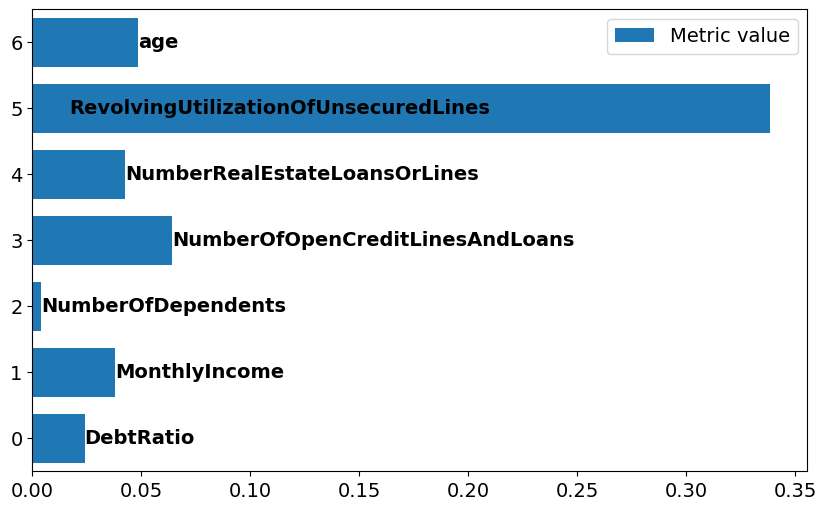

In [41]:
df_val.plot.barh(figsize=(10, 6))
ax=plt.gca()
ax.barh(df_val['Feature'], df_val['Metric value'], height=0.75)
_, xmax = plt.xlim()
for i, row in df_val.iterrows():
    ax.text(row['Metric value'] if 2*row['Metric value'] < xmax else xmax-row['Metric value'], 
            i, row['Feature'], color='black', fontweight='bold', fontsize=14, ha='left', va='center')

In [57]:
disc_data_encoded['RevolvingUtilizationOfUnsecuredLines_2'].mean()

0.3003284842796809

In [42]:
df_val.sort_values(by='Metric value', ascending=True)

,Feature,Metric value
2,NumberOfDependents,0.003915
0,DebtRatio,0.023985
1,MonthlyIncome,0.037991
4,NumberRealEstateLoansOrLines,0.04255
6,age,0.04856
3,NumberOfOpenCreditLinesAndLoans,0.064241
5,RevolvingUtilizationOfUnsecuredLines,0.338584


In [28]:
from sklearn.metrics import roc_auc_score, log_loss
from copy import copy

In [30]:
def elimination_experiment(model, data_dict, metric_dict, importances, direction='asc'):
    ordered_features = importances.sort_values(by='Metric value', ascending=(direction=='asc'))
    ordered_features = ordered_features['Feature'].tolist()
    df_res = pd.DataFrame(columns=['n_features', 'last_excluded']+[m_name for m_name in metric_dict.keys()]\
                                                                +[m_name+'_change, %' for m_name in metric_dict.keys()])
    for i in range(len(ordered_features)):
        model_c = copy(model)
        features_chosen = ordered_features[i:]
        model_c.fit(data_dict['train'][features_chosen], data_dict['train'][target])

        y_pred_test = model_c.predict_proba(data_dict['test'][features_chosen])[:, 1]
        metrics_vals = []
        metrics_chng=[]
        for m_name, metric in metric_dict.items():
            val = metric(data_dict['test'][target], y_pred_test)
            metrics_vals.append(np.round(val, 3))
            if i == 0:
                metrics_chng.append(0)
            else:
                base = df_res.loc[0, m_name]
                metrics_chng.append(np.round((val-base)/base*100, 3))
        df_res.loc[i, :] = [len(features_chosen), ordered_features[i-1] if i > 0 else '-']+metrics_vals+metrics_chng
    return df_res



In [ ]:
metric_dict = {
    'ROC AUC': lambda x, y: roc_auc_score(x,y)*100,
    'log_loss': lambda x, y: log_loss(x, y)
}

data_dict = {'train': data_train,
             'test': data_test,
             'val': data_val}

elimination_experiment(model, data_dict, metric_dict,
                       df_val, 'asc')

In [99]:
elimination_experiment(model, data_dict, metric_dict,
                       df_val, 'desc')

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,7,-,80.189,0.391,0,0
1,6,RevolvingUtilizationOfUnsecuredLines,72.313,0.43,-9.822,9.851
2,5,NumberOfOpenCreditLinesAndLoans,68.604,0.446,-14.447,14.14
3,4,age,67.055,0.452,-16.379,15.57
4,3,NumberRealEstateLoansOrLines,65.675,0.456,-18.1,16.513
5,2,MonthlyIncome,56.868,0.471,-29.083,20.551
6,1,DebtRatio,55.076,0.476,-31.317,21.618


In [32]:
def add_extra_features(data, features_orig,extra_size=0.5, mode='random', random_seed=42):
    extra_cnt = round(len(features_orig)/(1-extra_size))-len(features_orig)
    data_c = data.copy(deep=True)
    np.random.seed(random_seed)
    if mode=='random':
        for i in range(extra_cnt):
            std = np.random.uniform(0.75, 1.25)
            data_c[f'extra_{i+1}'] = np.random.normal(scale=std, size=data_c.shape[0])
    elif mode=='noisy':
        for i in range(extra_cnt):
            feature_chosen = np.random.choice(features_orig, size=1)[0]
            std = data[feature_chosen].std()
            data_c[f'extra_{i+1}'] = 0.5*data[feature_chosen]+0.5*np.random.normal(scale=std, size=data_c.shape[0])
    elif mode=='prod':
        first_subset=np.random.choice(features_orig, size=extra_cnt)
        second_subset=np.random.choice(features_orig, size=extra_cnt)
        i=0
        for feat1, feat2 in zip(first_subset, second_subset):
            data_c[f'extra_{i+1}'] = data[feat1]*data[feat2]
            i+=1
    return data_c

In [206]:
np.random.choice(features, 3)

array(['NumberOfOpenCreditLinesAndLoans', 'NumberOfDependents',
       'RevolvingUtilizationOfUnsecuredLines'], dtype='<U36')

In [33]:
from sklearn.feature_selection import SelectKBest

In [110]:
data_corr = add_extra_features(data, features, extra_size=0.75, mode='noisy')

In [111]:
data_dict_corr = {}

data_tv, data_dict_corr['test'] = train_test_split(data_corr, test_size=0.15, random_state=42,
                                      stratify=data_corr[target])

data_dict_corr['train'], data_dict_corr['val'] = train_test_split(data_tv, test_size=0.15, random_state=42,
                                      stratify=data_tv[target])

features_corr = list(data_corr.columns.difference([target]))

In [112]:
univ_sel = SelectKBest(k=len(features_corr))
univ_sel.fit(data_dict_corr['val'][features_corr], data_dict_corr['val'][target])

SelectKBest(k=28)

In [113]:
univ_sel.scores_

array([3.53346759e+00, 1.11572908e+01, 3.47371081e+00, 1.19869999e+02,
       3.72085916e+01, 4.04584783e-02, 3.11269809e+01, 2.54997454e+01,
       4.69406613e+00, 6.57024850e+01, 2.15935762e+01, 1.09556569e+01,
       1.23530115e+01, 6.61493211e+01, 6.14229947e+01, 7.11788115e-01,
       5.22935657e+01, 1.75320400e+01, 3.74590541e+01, 6.96108847e+00,
       1.89001971e-02, 1.24514926e+01, 8.94781223e-02, 2.05305605e+01,
       1.80929254e+01, 7.43546547e+00, 5.55778097e+01, 4.57944511e-01])

In [114]:
univ_sel.feature_names_in_

array(['DebtRatio', 'MonthlyIncome', 'NumberOfDependents',
       'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
       'RevolvingUtilizationOfUnsecuredLines', 'age', 'extra_1',
       'extra_10', 'extra_11', 'extra_12', 'extra_13', 'extra_14',
       'extra_15', 'extra_16', 'extra_17', 'extra_18', 'extra_19',
       'extra_2', 'extra_20', 'extra_21', 'extra_3', 'extra_4', 'extra_5',
       'extra_6', 'extra_7', 'extra_8', 'extra_9'], dtype=object)

In [115]:
data_dict_corr['train'].shape

(12075, 29)

In [116]:
model_corr = GradientBoostingClassifier(n_estimators=30)
#model = LogisticRegression()
model_corr.fit(data_dict_corr['train'][features_corr], data_dict_corr['train'][target])

GradientBoostingClassifier(n_estimators=30)

In [117]:
data_errors_corr = data_dict_corr['val'].copy(deep=True)
probs = model_corr.predict_proba(data_dict_corr['val'][features_corr])[:, 1]
data_errors_corr["inconf_error"] = (1-probs)*data_dict_corr['val'][target]+(probs)*(1-data_dict_corr['val'][target]) #inconfidence measure: the larger the worser inconfidence

data_errors_corr.drop(columns=[target], inplace=True)
data_errors_corr.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,extra_1,extra_2,extra_3,...,extra_13,extra_14,extra_15,extra_16,extra_17,extra_18,extra_19,extra_20,extra_21,inconf_error
700,1.000000,54,0.178841,3175.0,1,0,1,30.572440,0.343745,12.909635,...,1737.016886,16.419866,-0.231634,2.488706,83.574920,-0.087174,0.672298,2366.884297,102.450795,0.494420
15405,1.000000,35,0.000000,1800.0,0,0,0,23.027242,-0.913128,20.002182,...,-2919.007829,16.393033,0.773819,-2.460178,186.198540,-0.735215,-0.586139,2921.555002,254.862065,0.564254
16522,0.197965,49,0.120713,9708.0,7,2,2,30.293397,1.102639,32.365268,...,9798.859708,27.996607,4.505179,3.624687,80.397624,0.878648,2.279255,6894.369614,-185.463963,0.061758
3834,0.107234,80,0.271530,2960.0,8,1,0,45.016820,0.283824,46.110528,...,5170.613322,52.560995,3.385156,6.193151,-136.412079,8.253734,0.408696,1610.868399,673.128479,0.057409
10225,0.594406,39,0.537291,4665.0,6,1,4,22.249169,1.037219,17.171984,...,2934.072172,17.025361,0.872478,-2.496297,48.048375,3.652425,0.647400,6519.866728,-280.889530,0.179123


In [118]:
n_features_corr = len(features_corr)
disc_data_corr, pipeline_data_corr = discretize(data_errors_corr, 
                                      features_corr+["inconf_error"], icat=None, icont=list(range(n_features_corr+1)))
disc_data_corr

,DebtRatio,MonthlyIncome,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,RevolvingUtilizationOfUnsecuredLines,age,extra_1,extra_10,extra_11,...,extra_20,extra_21,extra_3,extra_4,extra_5,extra_6,extra_7,extra_8,extra_9,inconf_error
0,0,0,0,0,0,1,1,1,2,0,...,0,1,0,0,0,1,0,1,2,1
1,0,0,0,0,0,1,0,1,0,0,...,0,1,1,1,0,1,0,1,1,1
2,0,0,1,0,0,0,1,1,1,0,...,1,0,2,1,1,1,0,0,0,0
3,0,0,0,0,0,0,2,2,1,0,...,0,1,2,0,0,2,0,1,0,0
4,0,0,2,0,0,1,0,1,2,0,...,1,0,0,0,1,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,0,0,1,0,0,1,0,0,2,1,...,0,0,1,0,0,0,0,1,2,1
2127,0,0,0,0,0,1,0,1,0,0,...,0,0,1,1,1,0,0,1,0,1
2128,0,0,1,1,0,0,1,1,2,0,...,1,0,1,0,1,1,1,1,1,0
2129,0,0,0,0,0,1,0,1,1,0,...,0,1,0,1,0,2,0,0,1,1


In [119]:
q = np.linspace(0, 1, 11)
dicval_c = {feat: [data_errors_corr[feat].quantile(qu) for qu in q] for feat in pipeline_data_corr["cont_features"]}
#dicval
v = pipeline_data_corr["cont_features_edges"]
for i in [0, 2, 3, 5, 7]:
    v[i] = [v[i][0], dicval_c[pipeline_data_corr["cont_features"][i]][3], dicval_c[pipeline_data_corr["cont_features"][i]][7], v[i][3]]
pipeline_data_corr["transformer"].steps[0][1].bin_edges_ = v

In [120]:
disc_data_corr = pd.DataFrame(pipeline_data_corr["transformer"].transform(data_errors_corr), columns=data_errors_corr.columns)
disc_data_corr

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,extra_1,extra_2,extra_3,...,extra_13,extra_14,extra_15,extra_16,extra_17,extra_18,extra_19,extra_20,extra_21,inconf_error
0,2,1,0,0,0,1,0,2,1,0,...,0,0,0,0,2,0,1,0,1,1
1,2,0,0,0,0,1,0,1,0,1,...,0,0,0,0,2,0,0,0,1,1
2,1,1,0,2,0,2,1,2,1,2,...,1,1,1,1,2,0,2,1,0,0
3,0,2,1,0,0,2,0,2,1,2,...,1,2,1,1,0,2,1,0,1,0
4,1,0,2,1,0,2,2,1,1,0,...,0,0,0,0,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,2,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
2127,2,0,0,1,0,1,0,0,0,1,...,0,1,1,0,0,1,0,0,0,1
2128,1,1,0,2,1,2,1,2,1,1,...,1,1,1,1,2,1,1,1,0,0
2129,2,0,0,1,0,1,0,1,0,0,...,0,0,0,0,2,0,1,0,1,1


In [121]:
categories_corr = extract_categories(disc_data_corr)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded_corr = pd.DataFrame(encoder.fit_transform(X=disc_data_corr), columns=categories_corr, dtype='uint8')
disc_data_encoded_corr

,RevolvingUtilizationOfUnsecuredLines_0,RevolvingUtilizationOfUnsecuredLines_1,RevolvingUtilizationOfUnsecuredLines_2,age_0,age_1,age_2,DebtRatio_0,DebtRatio_1,DebtRatio_2,MonthlyIncome_0,...,extra_19_2,extra_20_0,extra_20_1,extra_20_2,extra_21_0,extra_21_1,extra_21_2,inconf_error_0,inconf_error_1,inconf_error_2
0,0,0,1,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
2,0,1,0,0,1,0,1,0,0,0,...,1,0,1,0,1,0,0,1,0,0
3,1,0,0,0,0,1,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
4,0,1,0,1,0,0,0,0,1,0,...,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
2127,0,0,1,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
2128,0,1,0,0,1,0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,0
2129,0,0,1,1,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0


In [122]:
feat_to_grad_corr = {}
for feat in features_corr:
    feat_to_grad_corr[feat]=[grad for grad in disc_data_encoded_corr.columns if feat in grad]
feat_to_grad_corr

{'DebtRatio': ['DebtRatio_0', 'DebtRatio_1', 'DebtRatio_2'],
 'MonthlyIncome': ['MonthlyIncome_0', 'MonthlyIncome_1', 'MonthlyIncome_2'],
 'NumberOfDependents': ['NumberOfDependents_0',
  'NumberOfDependents_1',
  'NumberOfDependents_2'],
 'NumberOfOpenCreditLinesAndLoans': ['NumberOfOpenCreditLinesAndLoans_0',
  'NumberOfOpenCreditLinesAndLoans_1',
  'NumberOfOpenCreditLinesAndLoans_2'],
 'NumberRealEstateLoansOrLines': ['NumberRealEstateLoansOrLines_1',
  'NumberRealEstateLoansOrLines_2'],
 'RevolvingUtilizationOfUnsecuredLines': ['RevolvingUtilizationOfUnsecuredLines_0',
  'RevolvingUtilizationOfUnsecuredLines_1',
  'RevolvingUtilizationOfUnsecuredLines_2'],
 'age': ['age_0', 'age_1', 'age_2'],
 'extra_1': ['extra_1_0',
  'extra_1_1',
  'extra_1_2',
  'extra_10_0',
  'extra_10_1',
  'extra_10_2',
  'extra_11_0',
  'extra_11_1',
  'extra_11_2',
  'extra_12_0',
  'extra_12_1',
  'extra_12_2',
  'extra_13_0',
  'extra_13_1',
  'extra_13_2',
  'extra_14_0',
  'extra_14_1',
  'extra_14_2

In [123]:
df_val_corr=error_based_importance_features(disc_data_encoded_corr, 'inconf_error', features_corr, feat_to_grad_corr)
df_val_corr

,Feature,Metric value
0,DebtRatio,0.021673
1,MonthlyIncome,0.036552
2,NumberOfDependents,0.001384
3,NumberOfOpenCreditLinesAndLoans,0.078671
4,NumberRealEstateLoansOrLines,0.048624
5,RevolvingUtilizationOfUnsecuredLines,0.304443
6,age,0.02283
7,extra_1,0.264468
8,extra_10,0.002286
9,extra_11,0.04474


In [124]:
df_val_corr_univ = copy(df_val_corr)
df_val_corr_univ['Feature']=univ_sel.feature_names_in_
df_val_corr_univ['Metric value']=univ_sel.pvalues_
df_val_corr_univ

,Feature,Metric value
0,DebtRatio,6.027834e-02
1,MonthlyIncome,8.514686e-04
2,NumberOfDependents,6.248885e-02
3,NumberOfOpenCreditLinesAndLoans,3.530377e-27
4,NumberRealEstateLoansOrLines,1.257226e-09
5,RevolvingUtilizationOfUnsecuredLines,8.406060e-01
6,age,2.724594e-08
7,extra_1,4.800654e-07
8,extra_10,3.037755e-02
9,extra_11,8.748520e-16


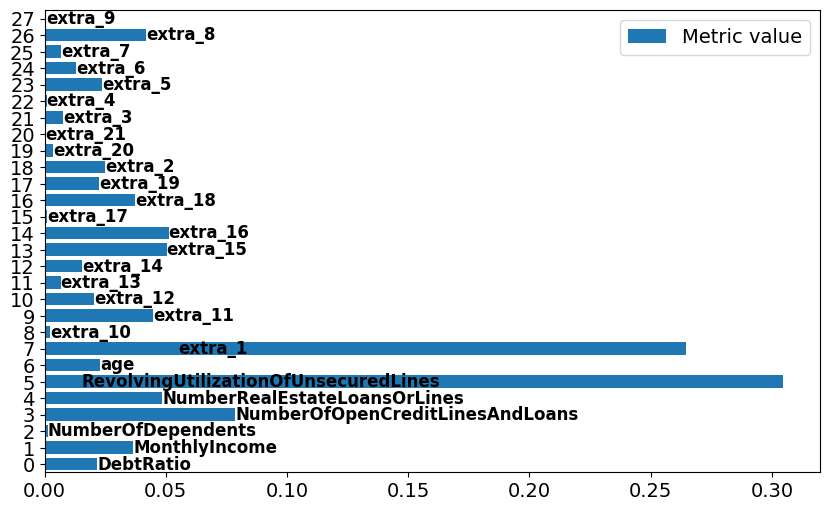

In [125]:
df_val_corr.plot.barh(figsize=(10, 6))
ax=plt.gca()
ax.barh(df_val_corr['Feature'], df_val_corr['Metric value'], height=0.75)
_, xmax = plt.xlim()
for i, row in df_val_corr.iterrows():
    ax.text(row['Metric value'] if 2*row['Metric value'] < xmax else xmax-row['Metric value'], 
            i, row['Feature'], color='black', fontweight='bold', fontsize=12, ha='left', va='center')

In [126]:
df_corr_excluded_asc=elimination_experiment(model_corr, data_dict_corr, metric_dict,
                       df_val_corr, 'asc')
df_corr_excluded_asc

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,28,-,79.868,0.393,0,0
1,27,extra_21,79.77,0.394,-0.123,0.138
2,26,extra_9,79.873,0.393,0.007,0.032
3,25,extra_4,79.892,0.393,0.03,-0.025
4,24,extra_17,80.033,0.392,0.206,-0.128
5,23,NumberOfDependents,79.871,0.393,0.004,0.07
6,22,extra_10,79.9,0.393,0.04,0.084
7,21,extra_20,79.801,0.394,-0.084,0.244
8,20,extra_13,79.735,0.395,-0.167,0.403
9,19,extra_7,79.92,0.394,0.065,0.184


In [127]:
df_corr_excluded_asc_univ=elimination_experiment(model_corr, data_dict_corr, metric_dict,
                       df_val_corr_univ, 'desc')
df_corr_excluded_asc_univ

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,28,-,79.868,0.393,0,0
1,27,extra_21,79.77,0.394,-0.123,0.139
2,26,RevolvingUtilizationOfUnsecuredLines,71.975,0.43,-9.882,9.437
3,25,extra_4,71.975,0.43,-9.882,9.437
4,24,extra_9,71.839,0.431,-10.052,9.591
5,23,extra_17,71.796,0.431,-10.106,9.637
6,22,NumberOfDependents,71.995,0.431,-9.857,9.641
7,21,DebtRatio,70.932,0.435,-11.188,10.725
8,20,extra_10,70.534,0.436,-11.687,11.015
9,19,extra_20,70.537,0.437,-11.683,11.139


In [128]:
df_corr_excluded_asc_univ=elimination_experiment(model_corr, data_dict_corr, metric_dict,
                       df_val_corr_univ, 'asc')
df_corr_excluded_asc_univ

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,28,-,79.868,0.393,0,0
1,27,NumberOfOpenCreditLinesAndLoans,79.378,0.397,-0.614,0.95
2,26,extra_15,79.397,0.397,-0.589,0.958
3,25,extra_11,79.426,0.396,-0.553,0.843
4,24,extra_16,79.607,0.396,-0.326,0.708
5,23,extra_8,79.522,0.396,-0.433,0.676
6,22,extra_18,79.581,0.395,-0.359,0.555
7,21,extra_2,79.579,0.396,-0.361,0.652
8,20,NumberRealEstateLoansOrLines,79.494,0.396,-0.468,0.679
9,19,age,79.497,0.396,-0.464,0.711


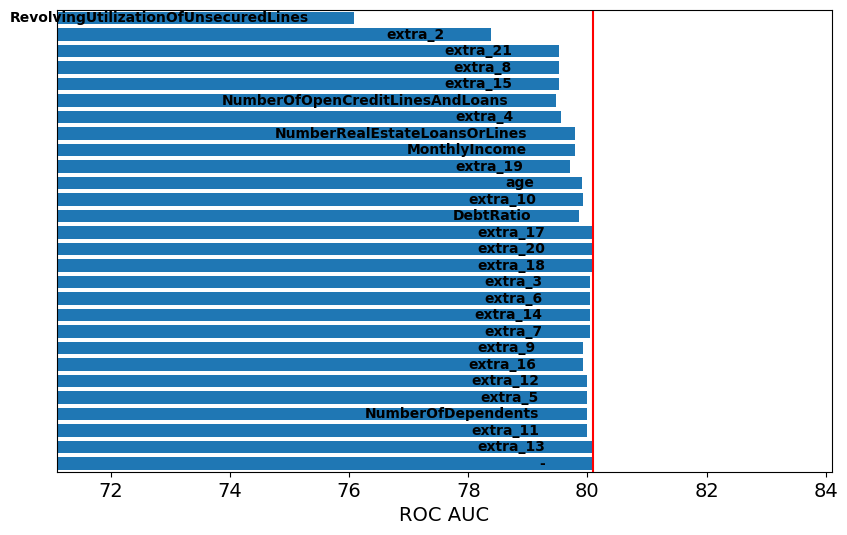

In [236]:
metr = 'ROC AUC'
df_corr_excluded_asc[['last_excluded', metr]].plot.barh(figsize=(10, 6))
ax=plt.gca()
ax.barh(df_corr_excluded_asc['last_excluded'], df_corr_excluded_asc[metr], height=0.75)
_, xmax = plt.xlim()
#ax.set_xlim((df_corr_excluded_asc[metr].min()-10, xmax))
for i, row in df_corr_excluded_asc.iterrows():
    ax.text(row[metr]*0.99,# if 2*row[metr] < xmax else xmax-row[metr], 
            i, row['last_excluded'], color='black', fontweight='bold', fontsize=10, ha='right', va='center')
ax.set_xlim((df_corr_excluded_asc[metr].min()-5, xmax))
ax.axvline(df_corr_excluded_asc.loc[0, metr], color='red')
ax.get_legend().remove()
ax.set_xlabel(metr)
ax.set_ylabel('Last removed feature')
ax.get_yaxis().set_visible(False)


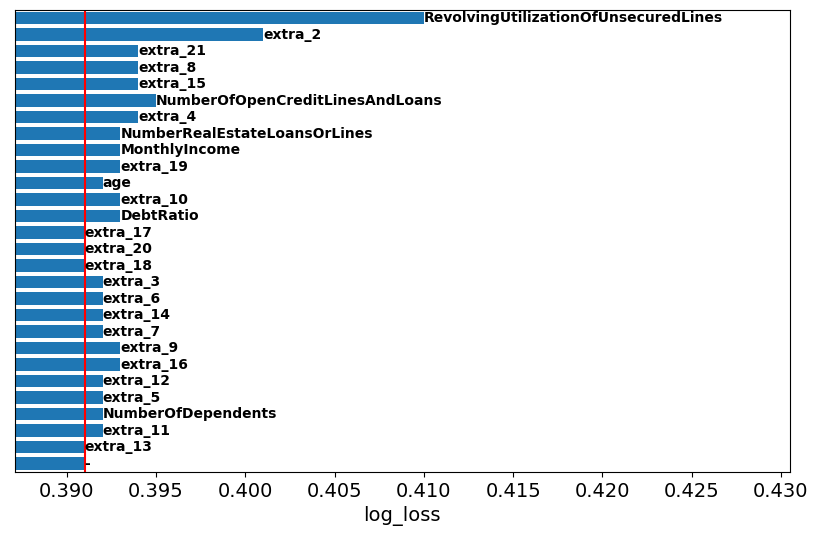

In [237]:
metr = 'log_loss'
df_corr_excluded_asc[['last_excluded', metr]].plot.barh(figsize=(10, 6))
ax=plt.gca()
ax.barh(df_corr_excluded_asc['last_excluded'], df_corr_excluded_asc[metr], height=0.75)
_, xmax = plt.xlim()
#ax.set_xlim((df_corr_excluded_asc[metr].min()-10, xmax))
for i, row in df_corr_excluded_asc.iterrows():
    ax.text(row[metr],# if 2*row[metr] < xmax else xmax-row[metr], 
            i, row['last_excluded'], color='black', fontweight='bold', fontsize=10, ha='left', va='center')
ax.set_xlim((df_corr_excluded_asc[metr].min()*0.99, xmax))
ax.axvline(df_corr_excluded_asc.loc[0, metr], color='red')
ax.get_legend().remove()
ax.set_xlabel(metr)
ax.set_ylabel('Last removed feature')
ax.get_yaxis().set_visible(False)


In [162]:
df_corr_excluded_asc[metr].min()-10

-9.609

In [101]:
elimination_experiment(model_corr, data_dict_corr, metric_dict,
                       df_val_corr, 'desc')

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,14,-,80.089,0.392,0,0
1,13,RevolvingUtilizationOfUnsecuredLines,71.856,0.431,-10.28,9.996
2,12,NumberOfOpenCreditLinesAndLoans,68.545,0.447,-14.415,13.987
3,11,NumberRealEstateLoansOrLines,67.653,0.45,-15.527,14.864
4,10,MonthlyIncome,62.352,0.463,-22.147,18.155
5,9,age,56.637,0.472,-29.282,20.436
6,8,DebtRatio,53.416,0.48,-33.304,22.353
7,7,extra_7,54.545,0.478,-31.895,21.987
8,6,extra_3,54.271,0.477,-32.237,21.793
9,5,NumberOfDependents,51.456,0.479,-35.751,22.173


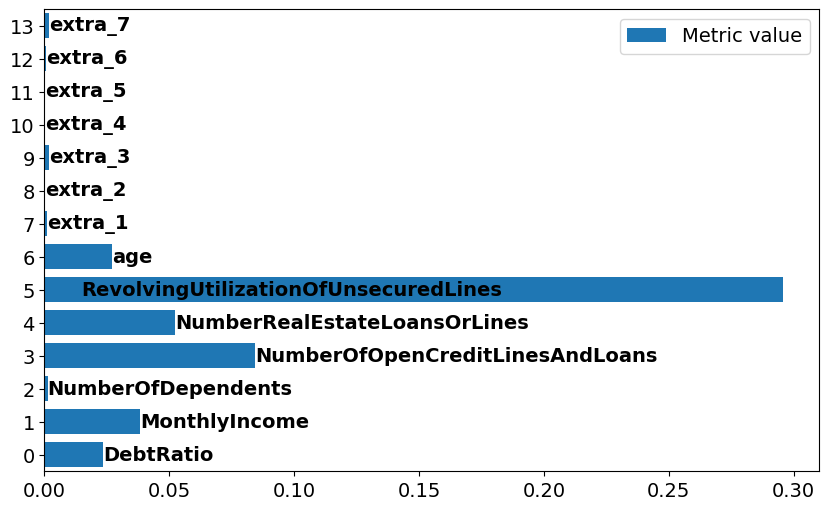

In [94]:
df_val_corr.plot.barh(figsize=(10, 6))
ax=plt.gca()
ax.barh(df_val_corr['Feature'], df_val_corr['Metric value'], height=0.75)
_, xmax = plt.xlim()
for i, row in df_val_corr.iterrows():
    ax.text(row['Metric value'] if 2*row['Metric value'] < xmax else xmax-row['Metric value'], 
            i, row['Feature'], color='black', fontweight='bold', fontsize=14, ha='left', va='center')

In [ ]:
df_val_corr=error_based_importance_features(disc_data_encoded, 'inconf_error', features)
df_val_corr

In [ ]:
# наша метрика -- это же по сути взаимная информация

In [71]:
from sklearn.feature_selection import mutual_info_classif

In [72]:
mutual_info_classif(X=disc_data[['age']], y=disc_data['inconf_error'])

array([0.05289194])

In [63]:
disc_data

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,inconf_error
0,2,1,0,0,0,1,0,2
1,2,0,0,0,0,1,0,2
2,1,1,0,2,0,2,1,0
3,0,2,1,0,0,2,0,0
4,1,0,2,1,0,2,2,1
...,...,...,...,...,...,...,...,...
2126,2,0,0,0,0,1,1,2
2127,2,0,0,1,0,1,0,2
2128,1,1,0,2,1,2,1,1
2129,2,0,0,1,0,1,0,2
